In [17]:
%matplotlib inline

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D
import Simple_RCWA

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Visualize Sampling Track (NO dict adding)

In [21]:
path_material_name = 'absorber'

path_all_data_visual = './data/' + path_material_name + '/dict_add/all_data_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params = data['params']
spectra_R = data['R'] #[N,N_freq]
spectra_T = data['T']

print('*** all_data')
print('params.shape:', params.shape)
print('spectra_R.shape:', spectra_R.shape)
print('-----------------------')

path_all_data_visual = './data/' + path_material_name + '/dict_add/all_data_visual_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params = data['params']
spectra_R = data['R'] #[N,N_freq]
spectra_T = data['T']

print('*** all_data_visual')
print('params.shape:', params.shape)
print('spectra_R.shape:', spectra_R.shape)
print('-----------------------')

path_all_data_visual = './data/' + path_material_name + '/dict_add/data_dict_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params = data['params']
spectra_R = data['R'] #[N,N_freq]
spectra_T = data['T']

print('*** data_dict')
print('params.shape:', params.shape)
print('spectra_R.shape:', spectra_R.shape)
print('-----------------------')


for idx_round in range(3):
    path_all_data_visual = './data/' + path_material_name + '/dict_add/all_data_' + path_material_name + '_ROUND_' + str(idx_round+1) + '.npz'
    data = np.load(path_all_data_visual)
    params = data['params']
    spectra_R = data['R'] #[N,N_freq]
    spectra_T = data['T']

    print('params.shape:', params.shape)
    print('spectra_R.shape:', spectra_R.shape)
    
    
path_all_data_visual = './data/' + path_material_name + '/dict_add/params_pick_visual_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params = data['params']

print('-----------------------')
print('*** params_pick_visual')
print('params.shape:', params.shape)


*** all_data
params.shape: (618, 4)
spectra_R.shape: (618, 222)
-----------------------
*** all_data_visual
params.shape: (600, 4)
spectra_R.shape: (600, 222)
-----------------------
*** data_dict
params.shape: (620, 4)
spectra_R.shape: (620, 222)
-----------------------
params.shape: (200, 4)
spectra_R.shape: (200, 222)
params.shape: (200, 4)
spectra_R.shape: (200, 222)
params.shape: (200, 4)
spectra_R.shape: (200, 222)
-----------------------
*** params_pick_visual
params.shape: (30, 4)


In [22]:
path_material_name = 'absorber'

path_all_data_visual = './data/' + path_material_name + '/dict_add/all_data_visual_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params_sampling = data['params']
spectra_R_sampling = data['R'] #[N,N_freq]
spectra_T_sampling = data['T']

print('*** all_data_visual')
print('params.shape:', params_sampling.shape)
print('spectra_R.shape:', spectra_R_sampling.shape)
print('-----------------------')


path_all_data_visual = './data/' + path_material_name + '/dict_add/params_pick_visual_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params_pick = data['params']

print('*** params_pick_visual')
print('params.shape:', params_pick.shape)

*** all_data_visual
params.shape: (600, 4)
spectra_R.shape: (600, 222)
-----------------------
*** params_pick_visual
params.shape: (30, 4)


num_rounds: 3


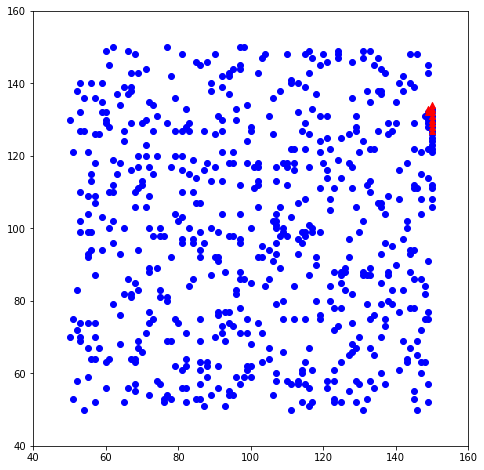

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML

# num_rounds = 3

n_sampling = 200
n_pick = 10

num_rounds = int(params_sampling.shape[0] / n_sampling)
print('num_rounds:', num_rounds)

size_fig=(10,8)

fig, ax = plt.subplots(figsize=size_fig)
marker_size = 5 #upped this to make points more visible

def animate(idx):
    ROUND = idx//2
    """ Perform animation step. """
    #important - the figure is cleared and new axes are added
    fig.clear()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(40, 160), ylim=(40, 160))
    #the new axes must be re-formatted
    ax.set_xlim(40, 160)
    ax.set_ylim(40, 160)
    # and the elements for this frame are added
    x_sampling = params_sampling[:(ROUND+1)*n_sampling, 0]
    y_sampling = params_sampling[:(ROUND+1)*n_sampling, 1]
    
    x_pick = params_pick[(ROUND)*n_pick:(ROUND+1)*n_pick, 0]
    y_pick = params_pick[(ROUND)*n_pick:(ROUND+1)*n_pick, 1]
    
    if idx>0:  # enable this if dict is added to training points
        x_pick_last = params_pick[0:(ROUND)*n_pick, 0]
        y_pick_last = params_pick[0:(ROUND)*n_pick, 1]
        
        x_sampling = np.concatenate((x_sampling, x_pick_last), axis=0)
        y_sampling = np.concatenate((y_sampling, y_pick_last), axis=0)
    
    ax.scatter(x_sampling, y_sampling, c='b')
    if idx%2!=0:  # show picked params
        ax.scatter(x_pick, y_pick, c='r', marker = '^')

anim = animation.FuncAnimation(fig, animate, interval=1000, frames=2*num_rounds)
anim.save('./data/absorber/absorber_track_dict_add.gif', writer='pillow', fps=1)
HTML(anim.to_html5_video())

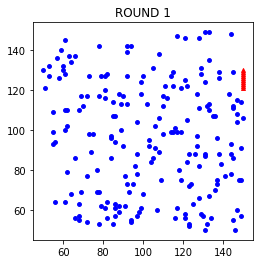

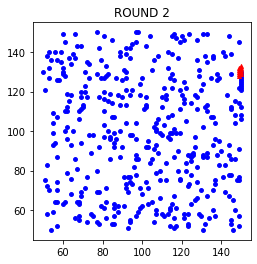

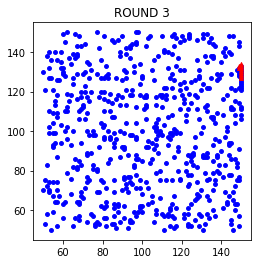

In [24]:
marker_size = 15 #upped this to make points more visible

for idx in range(num_rounds):
    x_sampling = params_sampling[:(idx+1)*n_sampling, 0]
    y_sampling = params_sampling[:(idx+1)*n_sampling, 1]
    
    x_pick = params_pick[(idx)*n_pick:(idx+1)*n_pick, 0]
    y_pick = params_pick[(idx)*n_pick:(idx+1)*n_pick, 1]
    
    if idx>0:  # enable this if dict is added to training points
        x_pick_last = params_pick[0:(idx)*n_pick, 0]
        y_pick_last = params_pick[0:(idx)*n_pick, 1]
        
        x_sampling = np.concatenate((x_sampling, x_pick_last), axis=0)
        y_sampling = np.concatenate((y_sampling, y_pick_last), axis=0)
    
    plt.scatter(x_sampling, y_sampling, c='b', s=marker_size)
    plt.scatter(x_pick, y_pick, c='r', marker = '^', s=marker_size)
    plt.title('ROUND '+str(idx+1))
    plt.gca().set_aspect('equal')
    plt.show()

# Visualize Sampling Track (dict adding)

In [25]:
path_material_name = 'absorber'

path_all_data_visual = './data/' + path_material_name + '/no_dict_add/all_data_visual_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params_sampling = data['params']
spectra_R_sampling = data['R'] #[N,N_freq]
spectra_T_sampling = data['T']

print('*** all_data_visual')
print('params.shape:', params_sampling.shape)
print('spectra_R.shape:', spectra_R_sampling.shape)
print('-----------------------')


path_all_data_visual = './data/' + path_material_name + '/no_dict_add/params_pick_visual_' + path_material_name + '.npz'
data = np.load(path_all_data_visual)
params_pick = data['params']

print('*** params_pick_visual')
print('params.shape:', params_pick.shape)

*** all_data_visual
params.shape: (2000, 4)
spectra_R.shape: (2000, 222)
-----------------------
*** params_pick_visual
params.shape: (100, 4)


num_rounds: 10


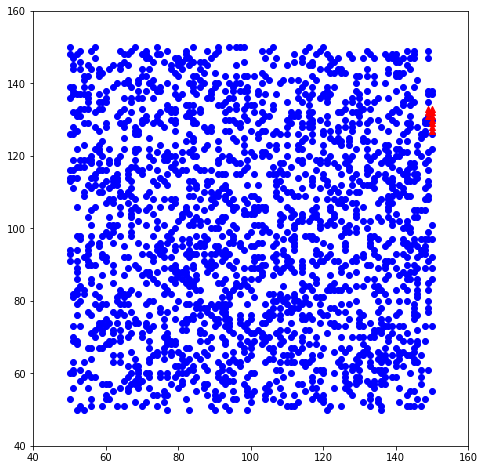

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML

# num_rounds = 3

n_sampling = 200  # num of sampling points per round
n_pick = 10

num_rounds = int(params_sampling.shape[0] / n_sampling)
print('num_rounds:', num_rounds)

size_fig=(10,8)

fig, ax = plt.subplots(figsize=size_fig)
marker_size = 5 #upped this to make points more visible

def animate(idx):
    ROUND = idx//2
    """ Perform animation step. """
    #important - the figure is cleared and new axes are added
    fig.clear()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(40, 160), ylim=(40, 160))
    #the new axes must be re-formatted
    ax.set_xlim(40, 160)
    ax.set_ylim(40, 160)
    # and the elements for this frame are added
    x_sampling = params_sampling[:(ROUND+1)*n_sampling, 0]
    y_sampling = params_sampling[:(ROUND+1)*n_sampling, 1]
    
    x_pick = params_pick[(ROUND)*n_pick:(ROUND+1)*n_pick, 0]
    y_pick = params_pick[(ROUND)*n_pick:(ROUND+1)*n_pick, 1]
    
#     if idx>0:  # enable this if dict is added to training points
#         x_pick_last = params_pick[0:(ROUND)*n_pick, 0]
#         y_pick_last = params_pick[0:(ROUND)*n_pick, 1]
        
#         x_sampling = np.concatenate((x_sampling, x_pick_last), axis=0)
#         y_sampling = np.concatenate((y_sampling, y_pick_last), axis=0)
    
    ax.scatter(x_sampling, y_sampling, c='b')
    if idx%2!=0:  # show picked params
        ax.scatter(x_pick, y_pick, c='r', marker = '^')

anim = animation.FuncAnimation(fig, animate, interval=1000, frames=2*num_rounds)
anim.save('./data/absorber/absorber_track_no_dict_add.gif', writer='pillow', fps=1)
HTML(anim.to_html5_video())

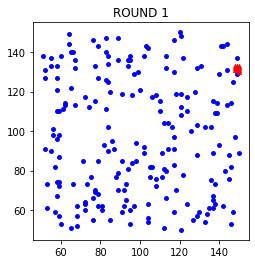

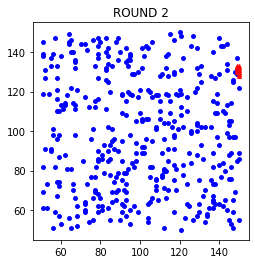

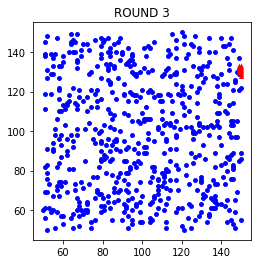

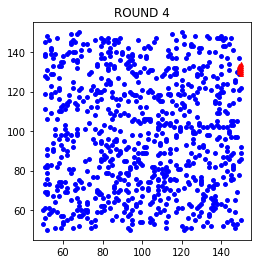

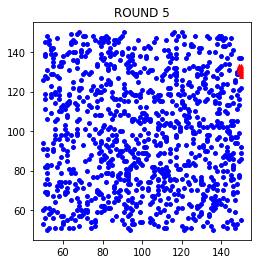

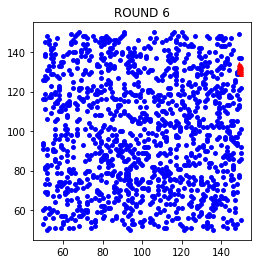

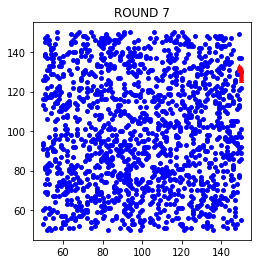

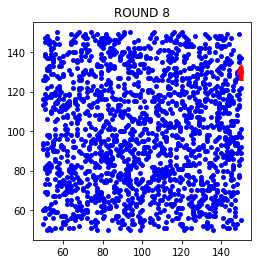

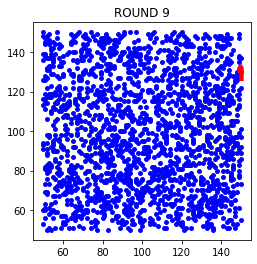

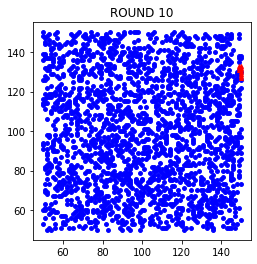

In [27]:
marker_size = 15 #upped this to make points more visible

for idx in range(num_rounds):
    x_sampling = params_sampling[:(idx+1)*n_sampling, 0]
    y_sampling = params_sampling[:(idx+1)*n_sampling, 1]
    
    x_pick = params_pick[(idx)*n_pick:(idx+1)*n_pick, 0]
    y_pick = params_pick[(idx)*n_pick:(idx+1)*n_pick, 1]
    
#     if idx>0:  # enable this if dict is added to training points
#         x_pick_last = params_pick[0:(idx)*n_pick, 0]
#         y_pick_last = params_pick[0:(idx)*n_pick, 1]
        
#         x_sampling = np.concatenate((x_sampling, x_pick_last), axis=0)
#         y_sampling = np.concatenate((y_sampling, y_pick_last), axis=0)
    
    plt.scatter(x_sampling, y_sampling, c='b', s=marker_size)
    plt.scatter(x_pick, y_pick, c='r', marker = '^', s=marker_size)
    plt.title('ROUND '+str(idx+1))
    plt.gca().set_aspect('equal')
    plt.show()